# Figure 1 Diagrams

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from requirements import *
data_dir = data_dir / 'xenium_nsclc'

from segger.data.parquet._ndtree import NDTree
from segger.data.parquet._utils import read_parquet_region, load_settings
from sg_utils.pl.plot_segmentation import plot_segmentation_boundaries
from matplotlib.patches import Polygon, Path
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

### Build NDtree for Visualization

In [556]:
# Read in AnnDatas
transcripts = pd.read_parquet(data_dir / 'labeled_transcripts_v2.parquet')

In [557]:
data = transcripts[['x_location', 'y_location']]
ndtree = NDTree(data, n=50)
bounds = shapely.box(*ndtree.rect.mins, *ndtree.rect.maxes)

In [558]:
xmin, ymin = ndtree.rect.mins
xmax, ymax = ndtree.rect.maxes
xdim = xmax - xmin
ydim = ymax - ymin

In [559]:
width = 200
xgb, xbins = pd.cut(
    data['x_location'],
    np.arange(xmin-1, xmax+1, width),
    retbins=True
)
ygb, ybins = pd.cut(
    data['y_location'],
    np.arange(ymin-1, ymax+1, width),
    retbins=True
)
sizes = data.groupby([xgb, ygb]).size().unstack().T

(3.693697929382324, 10880.1943359375, 4.276372909545898, 21665.056640625)

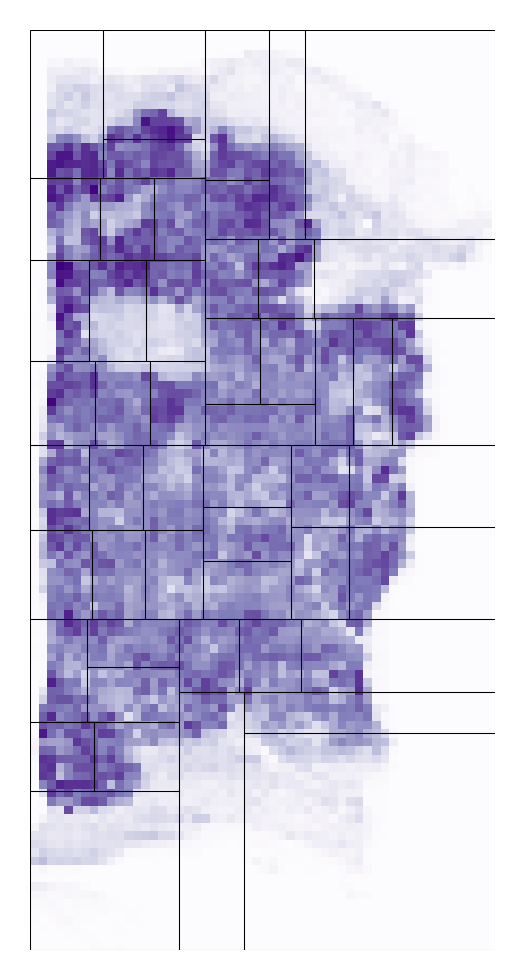

In [563]:
fig, ax = plt.subplots(
    1, 1,
    figsize=(2, 2 * (ydim / xdim)),
)

# Background densities
ax.pcolormesh(
    xbins, ybins,
    sizes, #.replace(0, np.nan),
    rasterized=True,
    cmap='Purples',
    vmin=0,
    vmax=np.quantile(sizes.values.flatten(), 0.9999),
)

# Patches
for b in ndtree.boxes:
    styles = dict(color='k', lw=.25, fill=False)
    poly = Polygon(np.array(b.exterior.coords.xy).T, **styles)
    styles = dict(color='k', lw=.25, fill=False)
    poly = Polygon(np.array(b.exterior.coords.xy).T, **styles)
    ax.add_patch(poly)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('off')
#fig.savefig(media_dir / 'diagrams/balanced_tiling.svg')
#plt.close()

### Toy Graph Construction

In [13]:
import xml.etree.ElementTree as ET
from scipy.spatial import KDTree
import numpy as np

def extract_circle_centers(svg_file):
    tree = ET.parse(svg_file)
    root = tree.getroot()

    # Find all circle elements (considering namespace)
    ns = {'svg': 'http://www.w3.org/2000/svg'}
    circles = root.findall('.//svg:circle', ns)

    # Extract center coordinates
    centers = []
    for circle in circles:
        cx = float(circle.get('cx', 0))
        cy = float(circle.get('cy', 0))
        centers.append((cx, cy))

    return np.array(centers)

In [10]:
tree = ET.parse(svg_file)

In [28]:
# Get centers and build graph
svg_file = media_dir / 'diagrams' / 'points.svg'
centers = extract_circle_centers(svg_file)
tree = KDTree(centers)
dist, idx = tree.query(centers, 6, distance_upper_bound=20)
idx = np.where(idx == len(centers), -1, idx)

In [41]:
collection = []
for neighbors in idx:
    c = neighbors[0]
    for n in neighbors[1:]:
        if n != -1:
            collection.append([centers[c], centers[n]])

collection = LineCollection(collection, lw=0.25, color='k')

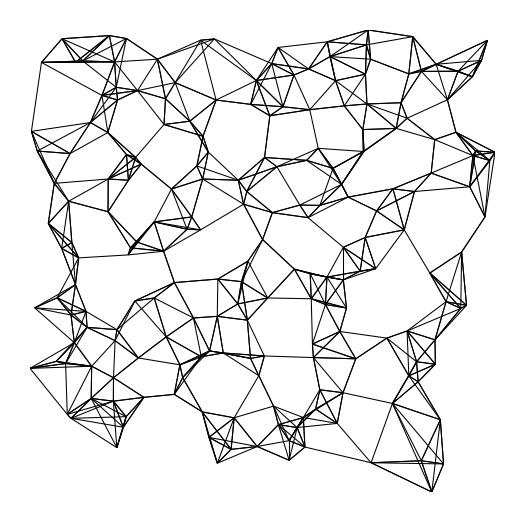

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.set_xlim(centers.T[0].min(), centers.T[0].max())
ax.set_ylim(centers.T[1].min(), centers.T[1].max())
ax.add_collection(collection)
ax.axis('off')
fig.savefig(media_dir / 'diagrams' / 'edges.svg')

### Example Graph Construction

In [504]:
# Region to plot
xmin, ymin, xmax, ymax = 5805, 15425, 5865, 15485
region = shapely.box(xmin, ymin, xmax, ymax)

In [505]:
# Read and filter membrane/DAPI image
image_filepath = data_dir / 'segmentation_image.npy'
image = np.load(image_filepath)
mpp = 0.2125 * 2
image = image[
    int(ymin / mpp): int(ymax / mpp),
    int(xmin / mpp): int(xmax / mpp),
]
mem = np.tile(image[:, :, 1, np.newaxis], (1, 1, 3)) * np.array([0, 1, 1])
nuc = np.tile(image[:, :, 0, np.newaxis], (1, 1, 3)) * np.array([1, 0, 0])
image = (mem + nuc).astype('uint8')

In [518]:
# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts_v2.parquet'
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    transcripts_filepath,
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=['cellpose_cell_type', 'cellpose_cell_id'],
)
is_epithelial = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
transcripts['is_epithelial'] = is_epithelial

transcripts = transcripts.sample(frac=0.2)
transcripts.x_location -= xmin
transcripts.x_location /= mpp
transcripts.y_location -= ymin
transcripts.y_location /= mpp

In [548]:
from scipy.spatial import KDTree
coords = transcripts[['x_location', 'y_location']].values
tree = KDTree(coords)
dist, idx = tree.query(coords, 6, distance_upper_bound=10)
idx = np.where(idx == len(coords), -1, idx)

In [554]:
import random

collection = []
for neighbors in idx:
    c = neighbors[0]
    for n in neighbors[1:]:
        if n != -1:
            if random.random() > 0.:
                collection.append([coords[c], coords[n]])

collection = LineCollection(collection, lw=0.1, alpha=0.5, color='w')

(-0.5, 141.5, 147.94423065185546, -0.5)

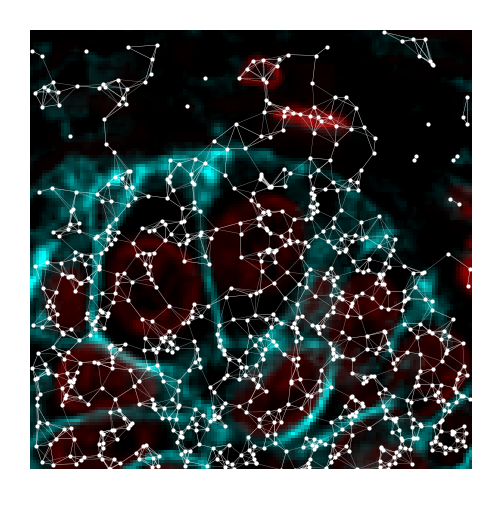

In [555]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(image)
ax.scatter(
    transcripts.x_location,
    transcripts.y_location,
    s=1, lw=0,
    c='w',
)

ax.add_collection(collection)
ax.axis('off')